## POS tagging using modified Viterbi

### Data Preparation

In [612]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.tokenize import word_tokenize

In [613]:
# nltk.download()
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [614]:
# first few tagged sentences
print(nltk_data[:10])
print(len(nltk_data))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Build the vanilla Viterbi based POS tagger

#### Splitting the nltk dataset into training and validation

In [615]:
# Splitting into train and validation
random.seed(222)
train_set, val_set = train_test_split(nltk_data,test_size=0.05, random_state=1111)

print(len(train_set))
print(len(val_set))


3718
196


In [616]:
# Explore the train set
print(train_set[:5])

[[('The', 'DET'), ('city', 'NOUN'), ("'s", 'PRT'), ('Campaign', 'NOUN'), ('Finance', 'NOUN'), ('Board', 'NOUN'), ('has', 'VERB'), ('refused', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('pay', 'VERB'), ('Mr.', 'NOUN'), ('Dinkins', 'NOUN'), ('$', '.'), ('95,142', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('matching', 'ADJ'), ('funds', 'NOUN'), ('because', 'ADP'), ('his', 'PRON'), ('campaign', 'NOUN'), ('records', 'NOUN'), ('are', 'VERB'), ('incomplete', 'ADJ'), ('.', '.')], [('Its', 'PRON'), ('net', 'ADJ'), ('income', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('September', 'NOUN'), ('quarter', 'NOUN'), ('rose', 'VERB'), ('about', 'ADP'), ('41', 'NUM'), ('%', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('year', 'NOUN'), ('ago', 'ADP'), ('.', '.')], [('Analysts', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('fall', 'NOUN'), ('in', 'ADP'), ('pretax', 'NOUN'), ('profit', 'NOUN'), ('was', 'VERB'), ('due', 'ADJ'), ('to', 'PRT'), ('the', 'DET'), ('group', 'NOUN'), ("'s", 'PRT'), ('recent', 'ADJ'),

In [617]:
# Explore the val set
print(val_set[:5])

[[('``', '.'), ('That', 'DET'), ('attracts', 'VERB'), ('attention', 'NOUN'), ('...', '.')], [('A', 'DET'), ('faster', 'ADJ'), ('version', 'NOUN'), (',', '.'), ('the', 'DET'), ('SuperDot', 'NOUN'), (',', '.'), ('was', 'VERB'), ('launched', 'VERB'), ('*-1', 'X'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('Wellcome', 'NOUN'), ('gained', 'VERB'), ('18', 'NUM'), ('to', 'PRT'), ('666', 'NUM'), ('on', 'ADP'), ('a', 'DET'), ('modest', 'ADJ'), ('1.1', 'NUM'), ('million', 'NUM'), ('shares', 'NOUN'), ('.', '.')], [('``', '.'), ('We', 'PRON'), ("'re", 'VERB'), ('offering', 'VERB'), ('this', 'DET'), ('plan', 'NOUN'), ('now', 'ADV'), ('because', 'ADP'), ('we', 'PRON'), ('feel', 'VERB'), ('0', 'X'), ('it', 'PRON'), ("'s", 'VERB'), ('the', 'DET'), ('right', 'ADJ'), ('time', 'NOUN'), ('.', '.'), ("''", '.')], [('The', 'DET'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), ('County', 'NOUN'), ('district', 'NOUN'), ('attorney', 'NOUN'), ("'s", 'PRT'), ('office', 'NOUN'), ('filed', 'VERB'), ('seven', 'NUM'), 

#### Extract tokens and tags from train set

In [618]:
# Get list of all the tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)
train_tagged_words[:10]

[('The', 'DET'),
 ('city', 'NOUN'),
 ("'s", 'PRT'),
 ('Campaign', 'NOUN'),
 ('Finance', 'NOUN'),
 ('Board', 'NOUN'),
 ('has', 'VERB'),
 ('refused', 'VERB'),
 ('*-1', 'X'),
 ('to', 'PRT')]

In [619]:
# Extract tokens from the tagged words list
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'city',
 "'s",
 'Campaign',
 'Finance',
 'Board',
 'has',
 'refused',
 '*-1',
 'to']

In [620]:
# Eliminate duplicate words in the vocabulary
print('Number of total words in vocabulary: ',len(tokens))
V = set(tokens)
print('Number of unique words in vocabulary: ',len(V))

Number of total words in vocabulary:  95372
Number of unique words in vocabulary:  12041


In [621]:
# Extract all tags from tagged words list
tags = [pair[1] for pair in train_tagged_words]
tags[:10]

['DET', 'NOUN', 'PRT', 'NOUN', 'NOUN', 'NOUN', 'VERB', 'VERB', 'X', 'PRT']

In [622]:
# Eliminate duplicate tags in the vocabulary
print('Number of total tags in vocabulary: ',len(tags))
T = set(tags)
print('Number of unique tags in vocabulary: ',len(T))

Number of total tags in vocabulary:  95372
Number of unique tags in vocabulary:  12


#### Extract tokens from sample test file

In [623]:
# Read from sample test file
test_file = open("Test_sentences.txt", "r") 
test_set= test_file.read()
test_set

"Android is a mobile operating system developed by Google.\nAndroid has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\nGoogle and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\nTwitter is an online news and social networking service on which users post and interact with messages known as tweets.\nBefore entering politics, Donald Trump was a domineering businessman and a television personality.\nThe 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\nThis is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\nShow me the cheapest round trips from Dallas to Atlanta\nI would like to see flights from Denver to Philadelphia.\nShow me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\nNASA invited social media users to experience the launch of ICESAT-2 Satell

In [624]:
# Tokenize the sample test file into words
from nltk.tokenize import word_tokenize
test_words = word_tokenize(test_set)
test_words[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.']

#### Calculate Emission Probability

In [625]:
# Compute P(w/t): the probability of a word being emitted by a tag, i.e. Emission Probability
t = len(T)
v = len(V)
# Create a zero T x V matrix for storing P(w/t) values
w_given_t = np.zeros((t, v))

In [626]:
# Compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Calculate Transition Probability

In [627]:
# Compute P(t2/t1): tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#### Create tags matrix for representing P(tj given ti)

In [628]:
# Create a t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [629]:
tags_matrix

array([[9.28764641e-02, 5.76194786e-02, 1.72858432e-01, 2.75022537e-02,
        9.08025280e-02, 6.60054088e-02, 2.16411171e-03, 8.93597826e-02,
        8.10640231e-02, 5.30207381e-02, 4.47249785e-02, 2.21911639e-01],
       [3.65168527e-02, 4.68164799e-04, 1.18913859e-01, 8.89513083e-03,
        5.38389497e-02, 6.08614236e-02, 4.68164776e-03, 1.55430704e-01,
        3.88576761e-02, 5.61797768e-02, 1.17509365e-01, 3.47846448e-01],
       [1.74820926e-02, 4.85613680e-04, 5.22034708e-03, 4.45550568e-02,
        8.98385327e-03, 3.76350619e-03, 2.42806840e-04, 4.00631316e-02,
        2.19740197e-02, 1.25045525e-02, 2.05778807e-01, 6.38946235e-01],
       [1.63908333e-01, 1.06619988e-02, 5.49013354e-02, 7.55888000e-02,
        1.43061742e-01, 5.39465323e-02, 1.86028004e-01, 2.04964995e-01,
        2.86441762e-03, 2.54614893e-02, 1.60725657e-02, 6.25397861e-02],
       [3.92619595e-02, 7.50911830e-04, 3.23428452e-01, 3.49710360e-02,
        1.65200606e-02, 6.86547980e-02, 1.50182366e-03, 8.36

In [630]:
# Convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [631]:
tags_df

,.,CONJ,DET,X,ADP,PRON,PRT,VERB,NUM,ADV,ADJ,NOUN
.,0.092876,0.057619,0.172858,0.027502,0.090803,0.066005,0.002164,0.089360,0.081064,0.053021,0.044725,0.221912
CONJ,0.036517,0.000468,0.118914,0.008895,0.053839,0.060861,0.004682,0.155431,0.038858,0.056180,0.117509,0.347846
DET,0.017482,0.000486,0.005220,0.044555,0.008984,0.003764,0.000243,0.040063,0.021974,0.012505,0.205779,0.638946
X,0.163908,0.010662,0.054901,0.075589,0.143062,0.053947,0.186028,0.204965,0.002864,0.025461,0.016073,0.062540
ADP,0.039262,0.000751,0.323428,0.034971,0.016520,0.068655,0.001502,0.008367,0.062004,0.013195,0.106844,0.324501
PRON,0.040139,0.005017,0.009649,0.094558,0.022385,0.007719,0.012350,0.483211,0.007719,0.035893,0.071787,0.209572
PRT,0.042539,0.001963,0.099804,0.013416,0.019961,0.018325,0.001636,0.402487,0.057592,0.009490,0.084424,0.248364
VERB,0.034885,0.005594,0.133789,0.217388,0.091757,0.035739,0.031466,0.168441,0.022920,0.082589,0.064564,0.110869
NUM,0.117735,0.013711,0.002981,0.209836,0.034277,0.001490,0.027422,0.016990,0.185097,0.002981,0.033085,0.354396
ADV,0.136634,0.007261,0.068977,0.023762,0.118812,0.013861,0.013861,0.344554,0.032343,0.080198,0.127393,0.032343


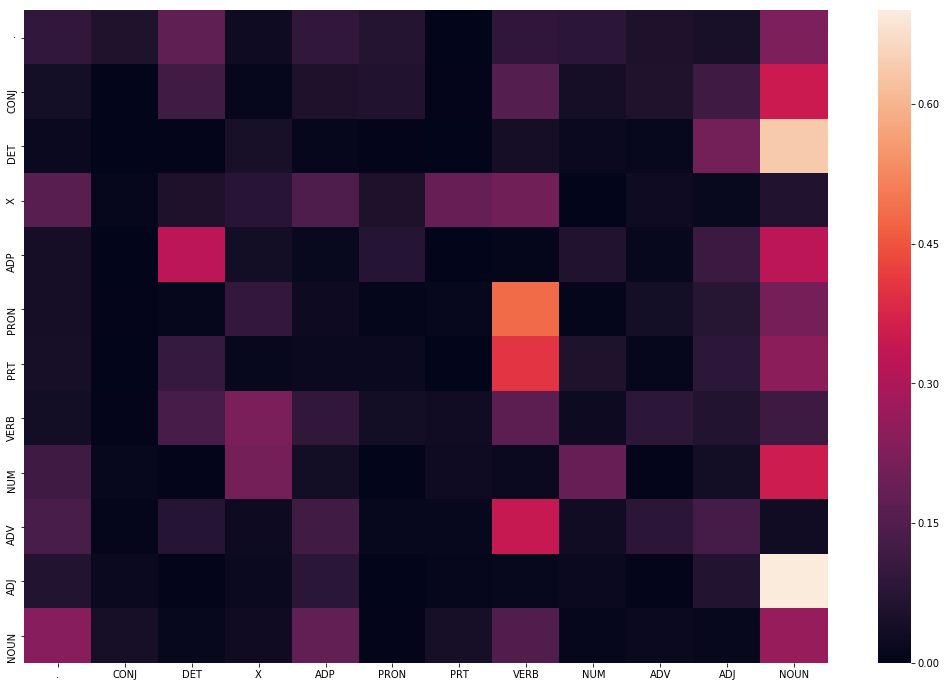

In [632]:
# Heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

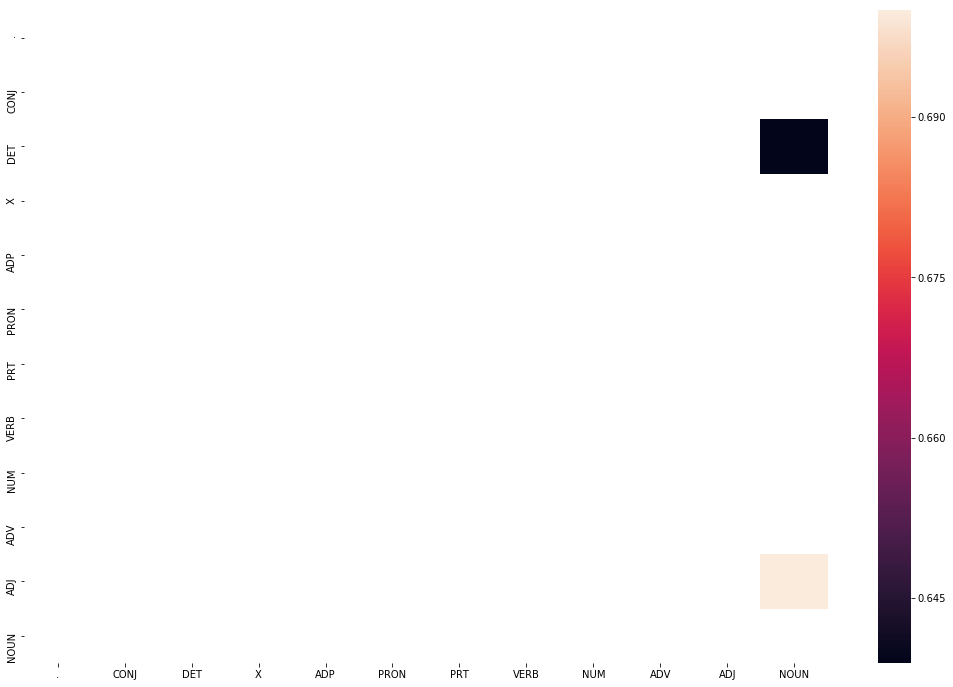

In [633]:
# Frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### Observation:
- The tag NOUN follows the tag DET with a transition probability of 0.690
- The tag NOUN follows the tag ADJ with a transition probability of 0.645

### Implement Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [634]:
len(train_tagged_words)

95372

In [635]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = [] 
        # iterate over all the tags in list T
        for tag in T:
            if key == 0: 
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]

            state_probability = emission_p * transition_p    
            p.append(state_probability)
          
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
        
    return list(zip(words, state))


### Evaluating tagging accuracy on Validation Set

In [636]:
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

#random.seed(222)

# choose random 5 sents
rndom = [random.randint(1,len(val_set)-1) for x in range(5)]
rndom
# list of sents
val_run = [val_set[i] for i in rndom]

# list of tagged words
val_run_base = [tup for sent in val_run for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_run for tup in sent]
#val_tagged_words

In [637]:
# tagging the validation set sentences
tagged_seq = Viterbi(val_tagged_words)


In [638]:
print(tagged_seq)

[('As', 'ADP'), ('San', 'NOUN'), ('Francisco', 'NOUN'), ('digs', '.'), ('out', 'ADP'), ('from', 'ADP'), ('The', 'DET'), ('Pretty', '.'), ('Big', 'NOUN'), ('One', 'NUM'), (',', '.'), ('opponents', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('the', 'DET'), ('last', 'ADJ'), ('thing', 'NOUN'), ('0', 'X'), ('the', 'DET'), ('city', 'NOUN'), ('can', 'VERB'), ('afford', '.'), ('*T*-1', 'X'), ('is', 'VERB'), ('an', 'DET'), ('expensive', 'ADJ'), ('new', 'ADJ'), ('stadium', 'NOUN'), ('.', '.'), ('Three', 'NUM'), ('divisions', 'NOUN'), ('at', 'ADP'), ('American', 'ADJ'), ('Express', 'NOUN'), ('*ICH*-1', 'X'), ('are', 'VERB'), ('working', 'VERB'), ('with', 'ADP'), ('Buick', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('promotion', 'NOUN'), (':', '.'), ('the', 'DET'), ('establishment', 'NOUN'), ('services', 'NOUN'), ('division', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-57', '.'), ('is', 'VERB'), ('responsible', 'ADJ'), ('for', 'ADP'), ('all', 'DET'), ('merchants', 'NOUN'), ('and', 'CONJ'), ('companies', 

In [639]:
# Calculate accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.8412698412698413

In [640]:
# Check incorrectly tagged tokens
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Francisco', 'NOUN'), (('digs', '.'), ('digs', 'VERB'))],
 [('digs', 'VERB'), (('out', 'ADP'), ('out', 'PRT'))],
 [('The', 'DET'), (('Pretty', '.'), ('Pretty', 'NOUN'))],
 [('can', 'VERB'), (('afford', '.'), ('afford', 'VERB'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('which', 'DET'), (('*T*-57', '.'), ('*T*-57', 'X'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('*', 'X'), (('Reducing', '.'), ('Reducing', 'VERB'))],
 [('their', 'PRON'), (('biannual', '.'), ('biannual', 'ADJ'))],
 [('biannual', 'ADJ'), (('powwow', '.'), ('powwow', 'NOUN'))],
 [('manufacturing', 'VERB'), (('titans', '.'), ('titans', 'NOUN'))],
 [('typically', 'ADV'), (('jet', 'NOUN'), ('jet', 'VERB'))],
 [('the', 'DET'), (('sunny', '.'), ('sunny', 'ADJ'))],
 [('sunny', 'ADJ'), (('confines', '.'), ('confines', 'NOUN'))],
 [('and', 'CONJ'), (('Hot', 'ADJ'), ('Hot', 'NOUN'))],
 [('A', 'DET'), (('player', '.'), ('player', 'NOUN'))],
 [('player', 'NOUN'), (("'s", 'VERB'), (

#### Observations:
- All the unknown words are assigned the first tag in the training set.
- The algorithm works well for words present in the training set though ambiguous words are sometimes incorrectly tagged when context changes.


### Evaluating tagging accuracy on Sample Test Set

In [641]:
# tagging the test sentences
tagged_seq = Viterbi(test_words)


In [642]:
tagged_seq

[('Android', '.'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', '.'),
 ('.', '.'),
 ('Android', '.'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', '.'),
 ('worldwide', '.'),
 ('on', 'ADP'),
 ('smartphones', '.'),
 ('since', 'ADP'),
 ('2011', '.'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', '.'),
 ('.', '.'),
 ('Google', '.'),
 ('and', 'CONJ'),
 ('Twitter', '.'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', '.'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', '.'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', '.'),
 ("'s", 'VERB'),
 ('firehose', '.'),
 ('.', '.'),
 ('Twitter', '.'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', '.'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which',

#### Observations:
- There are 28 unique unknown words in the test sample which appear 36 times in the sentences. 
        Android
        Google
        OS
        worldwide
        smartphones
        2011
        2013
        Twitter
        2015
        firehose
        online
        interact
        messages
        tweets
        domineering
        personality
        2018
        FIFA
        Cup
        21st
        tournament
        contested
        trips
        arriving
        NASA
        invited
        ICESAT-2
        Satellite
        
- All the unknown words are assigned the first tag in the training set (the '.' )

### Solve the problem of unknown words

### Technique 1: Use only Transition Probabilities to tag unknown words

Since the emission probabilities of all tags for unknown words are always zero (since they do not appear in the training set at all), we can use this knowledge to treat them differently. 
We know that state probabilties determine the most likely tag for each word, and it is in turn dependent on both transition and emission probabilities. So whenever emission probability is 0, the corresponding state probability is also 0. This makes determining the tags of unknown words difficult.
Let us only consider the transition probabilities in case of unknown words (since emission probabilities are 0 anyway) and assign them the tag with the maximum transition probability (from the previous tag).

In [643]:
# Modified Viterbi Heuristic - Technique 1
def ModifiedViterbi_1(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = [] 
        
        # initialise a variable that would store the sum of emission probabilities for all tags per observation
        sum_emission_p = 0
        
        # initialise list that would store transition probabilty values for all tags per observation
        tp = []
        # iterate over all tags in list T
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # append emission probability of tag to list
            tp.append(transition_p)
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
              
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # add emission probability of tag
            sum_emission_p += emission_p
        
        # If the sum of all emission probabilties is 0, then the word is unknown
        # Store the max of the transition probabilties in this case
        if sum_emission_p == 0:
            print('Unknown word: "{}", (will be assigned a tag with max transition probability)'.format(word))
            tmax = max(tp)
            # Get state for which transition probability is maximum
            state_max = T[tp.index(tmax)]
            
       # Else store max of the state probabilties      
        else: 
            pmax = max(p)
            # getting state for which state probability is maximum
            state_max = T[p.index(pmax)]
            

        state.append(state_max)
    return list(zip(words, state))

### Evaluating tagging accuracy on Validation Set

In [644]:
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

#random.seed(222)

# choose random 5 sents
rndom = [random.randint(1,len(val_set)-1) for x in range(5)]
rndom
# list of sents
val_run = [val_set[i] for i in rndom]

# list of tagged words
val_run_base = [tup for sent in val_run for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_run for tup in sent]
#val_tagged_words

In [645]:
# tagging the validation set sentences
tagged_seq = ModifiedViterbi_1(val_tagged_words)


Unknown word: "single-handed", (will be assigned a tag with max transition probability)
Unknown word: "imperative", (will be assigned a tag with max transition probability)
Unknown word: "natural-gas", (will be assigned a tag with max transition probability)
Unknown word: "disaffected", (will be assigned a tag with max transition probability)
Unknown word: "hard-drinking", (will be assigned a tag with max transition probability)
Unknown word: "nearly-30", (will be assigned a tag with max transition probability)
Unknown word: "snow", (will be assigned a tag with max transition probability)
Unknown word: "search", (will be assigned a tag with max transition probability)
Unknown word: "elusive", (will be assigned a tag with max transition probability)
Unknown word: "sheep", (will be assigned a tag with max transition probability)
Unknown word: "behest", (will be assigned a tag with max transition probability)
Unknown word: "sinister", (will be assigned a tag with max transition probabilit

In [646]:
print(tagged_seq)

[('As', 'ADP'), ('chairman', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('House', 'NOUN'), ('Energy', 'NOUN'), ('and', 'CONJ'), ('Commerce', 'NOUN'), ('Committee', 'NOUN'), (',', '.'), ('Mr.', 'NOUN'), ('Dingell', 'NOUN'), ('has', 'VERB'), ('almost', 'ADV'), ('single-handed', 'VERB'), ('control', 'NOUN'), ('over', 'ADP'), ('clean-air', 'ADJ'), ('legislation', 'NOUN'), ('.', '.'), ('To', 'PRT'), ('that', 'DET'), ('end', 'NOUN'), (',', '.'), ('American', 'NOUN'), ('Express', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('signing', 'VERB'), ('up', 'ADV'), ('gasoline', 'NOUN'), ('companies', 'NOUN'), (',', '.'), ('car', 'NOUN'), ('repair', 'NOUN'), ('shops', 'NOUN'), (',', '.'), ('tire', 'NOUN'), ('companies', 'NOUN'), ('and', 'CONJ'), ('car', 'NOUN'), ('dealers', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('accept', 'VERB'), ('the', 'DET'), ('card', 'NOUN'), ('.', '.'), ('``', '.'), ('*', 'X'), ('To', 'PRT'), ('avoid', 'VERB'), ('these', 'DET'), ('costs', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('a'

In [647]:
# Calculate accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.9044117647058824

In [648]:
# Check incorrectly tagged tokens
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('almost', 'ADV'), (('single-handed', 'VERB'), ('single-handed', 'ADJ'))],
 [('signing', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('is', 'VERB'), (('imperative', 'X'), ('imperative', 'ADJ'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('third-quarter', 'NOUN'), (('net', 'NOUN'), ('net', 'ADJ'))],
 [('A', 'DET'), (('disaffected', 'NOUN'), ('disaffected', 'ADJ'))],
 [(',', '.'), (('hard-drinking', 'NOUN'), ('hard-drinking', 'ADJ'))],
 [(',', '.'), (('nearly-30', 'NOUN'), ('nearly-30', 'ADJ'))],
 [('hero', 'NOUN'), (('sets', 'NOUN'), ('sets', 'VERB'))],
 [('an', 'DET'), (('elusive', 'NOUN'), ('elusive', 'ADJ'))],
 [('its', 'PRON'), (('back', 'ADV'), ('back', 'NOUN'))],
 [('a', 'DET'), (('sinister', 'NOUN'), ('sinister', 'ADJ'))],
 [(',', '.'), (('erudite', 'NOUN'), ('erudite', 'ADJ'))]]

#### Observations:

- Some of the unknown words are now being correctly tagged based off only the transition probabilities.

- The unknown words have now been matched to the tag which has the highest transition probability from its previous tag. For instance, if the transition probability from DET to NOUN is maximum of all states, any unknown word which follows any word with a POS tag of 'DET' will have the NOUN tag (For example, the unknown words 'elusive' and 'sinister')

- Since we are only tagging unknown words based on transition probabilities, the tagger still makes mistakes and has a lot of scope to improve. We will handle that in the next section

### Evaluating tagging accuracy on Sample Test Set

In [649]:
# tagging the test sentences
tagged_seq = ModifiedViterbi_1(test_words)


Unknown word: "Android", (will be assigned a tag with max transition probability)
Unknown word: "Google", (will be assigned a tag with max transition probability)
Unknown word: "Android", (will be assigned a tag with max transition probability)
Unknown word: "OS", (will be assigned a tag with max transition probability)
Unknown word: "worldwide", (will be assigned a tag with max transition probability)
Unknown word: "smartphones", (will be assigned a tag with max transition probability)
Unknown word: "2011", (will be assigned a tag with max transition probability)
Unknown word: "2013", (will be assigned a tag with max transition probability)
Unknown word: "Google", (will be assigned a tag with max transition probability)
Unknown word: "Twitter", (will be assigned a tag with max transition probability)
Unknown word: "2015", (will be assigned a tag with max transition probability)
Unknown word: "Google", (will be assigned a tag with max transition probability)
Unknown word: "Twitter", (w

In [650]:
tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

#### Observations:

- 'Android' has been properly tagged as NOUN in all cases.
- 'Google' has been tagged correctly as 'NOUN' twice and incorrectly as 'X' once.
- 'Twitter' has also been tagged correctly twice as NOUN and erroneously once, as VERB 
- Organization abbreviations like NASA, FIFA have been tagged correctly as NOUN.
- Years like 2011, 2013 and 2018 have been incorrectly tagged as NOUN
- 'ICESAT-2' which is the name of a satellite has been correctly tagged as NOUN
- Adjectival ordinal numerals like the word '21st'has been assigned the tag of NOUN
- The word 'arriving' has been incorrectly tagged as NOUN

### Technique 2: Use Rule-Based (Regular Expression) tagger to tag unknown words 

Now let's build a rule-based, or regular expression based tagger which captures morphological patterns in unknown words and use it to tag those words. 

In the example below, we specify regexes for gerunds and past tense verbs, 3rd singular present verb (creates, moves, makes etc.), modal verbs MD (should, would, could), possesive nouns (partner's, bank's etc.), plural nouns (banks, institutions), cardinal numbers CD, adjectival ordinal numerals and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NN.

In [651]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),                          # gerund
    (r'.*ed$', 'VERB'),                           # past tense
    (r'.*es$', 'VERB'),                           # 3rd singular present
    (r'.*ould$', 'VERB'),                         # modals
    (r'.[0-9]+\'?s$', 'NUM'),                     # Numbers like 90s or '90s
    (r'.*\'s$', 'NOUN'),                          # possessive nouns
    (r'.*s$', 'NOUN'),                            # plural nouns    
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),             # cardinal numbers
    (r'^-?[0-9]+(.[0-9]+)?(th|st|nd)$', 'ADJ'),   # adjectival ordinal numerals (like 21st, 9th, 2nd etc)
    (r'.*', 'NOUN')                               # nouns
]

In [652]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)


In [653]:
# Modified Viterbi Heuristic - Technique 2
def ModifiedViterbi_2(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # initialise list of probability column for a given observation
        p = [] 
        
        # initialise a variable that would store the sum of emission probabilities for all tags per observation
        sum_emission_p = 0
        
        # initialise list that would store transition probabilty values for all tags per observation
        tp = []
        # iterate over all tags in list T
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # append emission probability of tag to list
            tp.append(transition_p)
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
              
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # add emission probability of tag
            sum_emission_p += emission_p
        
        # If the sum of all emission probabilties is 0, then the word is unknown
        # Use the regular expression tagger to tag the unknown word
        if sum_emission_p == 0:
            print('Unknown word: "{}", (will be tagged using rule-based regex tagger)'.format(word))
            regex_tag = rule_based_tagger.tag(nltk.word_tokenize(word))
            state_max = regex_tag[0][1]
            
       # Else store max of the state probabilties      
        else: 
            pmax = max(p)
            # getting state for which state probability is maximum
            state_max = T[p.index(pmax)]
            
        state.append(state_max)
        
    return list(zip(words, state))

#### Evaluating tagging accuracy on Validation Set

In [654]:
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

#random.seed(222)

# choose random 5 sents
rndom = [random.randint(1,len(val_set)-1) for x in range(5)]
rndom
# list of sents
val_run = [val_set[i] for i in rndom]

# list of tagged words
val_run_base = [tup for sent in val_run for tup in sent]

# list of untagged words
val_tagged_words = [tup[0] for sent in val_run for tup in sent]
#val_tagged_words

In [655]:
# tagging the validation set sentences
tagged_seq = ModifiedViterbi_2(val_tagged_words)


Unknown word: "curbing", (will be tagged using rule-based regex tagger)
Unknown word: "darned", (will be tagged using rule-based regex tagger)
Unknown word: "participant", (will be tagged using rule-based regex tagger)
Unknown word: "incentive-bonus", (will be tagged using rule-based regex tagger)
Unknown word: "biscuit", (will be tagged using rule-based regex tagger)
Unknown word: "Lazzaroni", (will be tagged using rule-based regex tagger)
Unknown word: "overproduction", (will be tagged using rule-based regex tagger)


In [656]:
print(tagged_seq)

[('She', 'PRON'), ('adds', 'VERB'), ('that', 'ADP'), ('legislation', 'NOUN'), ('curbing', 'VERB'), ('it', 'PRON'), ('would', 'VERB'), ('be', 'VERB'), ('``', '.'), ('a', 'DET'), ('darned', 'VERB'), ('good', 'ADJ'), ('idea', 'NOUN'), ('.', '.'), ("''", '.'), ('Shearson', 'NOUN'), ('also', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('an', 'DET'), ('aggressive', 'ADJ'), ('participant', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('leveraged', 'ADJ'), ('buy-out', 'NOUN'), ('business', 'NOUN'), ('.', '.'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ("'s", 'PRT'), ('extra', 'ADJ'), ('work', 'NOUN'), ('was', 'VERB'), ('also', 'ADV'), ('helping', 'VERB'), ('her', 'PRON'), ('earn', 'VERB'), ('points', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('state', 'NOUN'), ("'s", 'PRT'), ('incentive-bonus', 'NOUN'), ('program', 'NOUN'), ('.', '.'), ('Two', 'NUM'), ('antitrust', 'ADJ'), ('agencies', 'NOUN'), ('may', 'VERB'), ('face', 'VERB'), ('further', 'ADV'), ('cutbacks', 'NOUN'), ('because', 'ADP'), ('of', 'ADP'),

In [657]:
# Calculate accuracy
check = [i for i, j in zip(tagged_seq, val_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.978494623655914

In [658]:
# Check incorrectly tagged tokens
incorrect_tagged_cases = [[val_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, val_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('a', 'DET'), (('darned', 'VERB'), ('darned', 'ADV'))],
 [('face', 'VERB'), (('further', 'ADV'), ('further', 'ADJ'))]]

#### Observations:

- Most of the unknown words are now being correctly tagged based on their morphological properties.

- The overall accuracy of the algorithm has increased significantly.

- There are still some unknown words which are ambiguous due to their context of use and hence they cannot be tagged properly by just observing their morphological characteristics.

#### Evaluating tagging accuracy on Sample Test Set

In [659]:
# tagging the test sentences
tagged_seq = ModifiedViterbi_2(test_words)


Unknown word: "Android", (will be tagged using rule-based regex tagger)
Unknown word: "Google", (will be tagged using rule-based regex tagger)
Unknown word: "Android", (will be tagged using rule-based regex tagger)
Unknown word: "OS", (will be tagged using rule-based regex tagger)
Unknown word: "worldwide", (will be tagged using rule-based regex tagger)
Unknown word: "smartphones", (will be tagged using rule-based regex tagger)
Unknown word: "2011", (will be tagged using rule-based regex tagger)
Unknown word: "2013", (will be tagged using rule-based regex tagger)
Unknown word: "Google", (will be tagged using rule-based regex tagger)
Unknown word: "Twitter", (will be tagged using rule-based regex tagger)
Unknown word: "2015", (will be tagged using rule-based regex tagger)
Unknown word: "Google", (will be tagged using rule-based regex tagger)
Unknown word: "Twitter", (will be tagged using rule-based regex tagger)
Unknown word: "firehose", (will be tagged using rule-based regex tagger)
Un

In [660]:
tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

#### Observations:
- 'Android' has been correctly tagged as NOUN in all cases.
- 'Google' has now been correctly tagged as'NOUN' in all occurances.
- 'Twitter' has now been correctly tagged as'NOUN' in all occurances. 
- Organization abbreviations like NASA, FIFA have been tagged correctly as NOUN.
- Years like 2011, 2013, 2015, 2018 have now been correctly tagged as NUM.
- 'ICESAT-2' which is the name of a satellite has been correctly tagged as NOUN.
- Adjectival ordinal numerals like the word '21st' has been correctly assigned the tag of ADJ.
- The word 'arriving' has been correctly tagged as  VERB.
- Verbs that start at the beginning of sentences like 'Show me the flights from so and so' are tagged as NOUN.

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Tagging accuracies on Validation Set 
####  Vanilla Viterbi:  ~84%

#### Viterbi with only Transition Probabilities for unknown words (Technique 1): ~91%

#### Viterbi with rule-based tagger for unknown words (Technique 2): ~98%
    

### Tagging accuracies on Test Sample (for unknown words only)
####  Vanilla Viterbi :
######  Accuracy : 0
     - All 36 occurances of unknown words are tagged to the first tag (".") in training set which are all incorrect.
     
####  Viterbi with only Transition Probabilities for unknown words (Technique 1):
######   Accuracy: (22/36) = ~61%
    - 22 occurances of unknown words (out of 36) have been tagged correctly.    
    - The following 14 (out of 36) unknown word occurances have been tagged incorrectly:

    ('2011', 'NOUN')
    ('2013', 'NOUN')
    ('2015', 'NOUN')
    ('Google', 'X')
    ('Twitter', 'VERB')
    ('firehose', 'VERB')
    ('online', 'NOUN')
    ('tweets', 'DET')
    ('domineering', 'NOUN')
    ('2018', 'NOUN')
    ('21st', 'NOUN')
    ('contested', 'NOUN')
    ('arriving', 'NOUN')
    ('invited', 'NOUN')

    
    
    
####  Viterbi with rule-based tagger for unknown words (Technique 2):
###### Accuracy: (32/36) = ~89%
    - 32(out of 36) occurances of unknown words have been tagged correctly.
    - The following 4 unknown word occurances have been tagged incorrectly:
    ('smartphones', 'VERB') 
    ('online', 'NOUN')      
    ('messages', 'VERB')    
    ('domineering', 'VERB') 
    
 

## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications



### Vanilla Viterbi 
     All 36 occurances of unknown words are tagged to the first tag in training set (".") which are all incorrect.
### Viterbi after modifications  (Techniques 1 & 2)
    - 'Android' has been correctly tagged as NOUN in all cases.
    - 'Google' has now been correctly tagged as'NOUN' in all occurances.
    - 'Twitter' has now been correctly tagged as'NOUN' in all occurances. 
    - Organization abbreviations like NASA, FIFA have been tagged correctly as NOUN.
    - Years like 2011, 2013, 2015, 2018 have now been correctly tagged as NUM.
    - 'ICESAT-2' which is the name of a satellite has now been correctly tagged as NOUN.
    - Adjectival ordinal numerals like the word '21st' has been correctly assigned the tag of ADJ.
    - The word 'arriving' has been correctly tagged as VERB.